In [8]:
import tensorflow as tf
import numpy as np
from flwr.common import (
    parameters_to_ndarrays
)
import json
import os
import cv2
from sklearn.metrics import classification_report,f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.mobilenet import MobileNet 
from keras.applications.mobilenet_v2 import MobileNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge 
from keras.applications.densenet import DenseNet169 

In [9]:
Categories = [
"Locker",
"Mediyes",
"Winwebsec",
"Zbot",
"Zeroaccess"
]
img_width = 64
img_height = 64
img_dim = 1

In [10]:
def get_base_model(model_name):
    if img_dim == 1:
        img_input = Input(shape=(img_width, img_height, 1))
        img_conc = Concatenate()([img_input, img_input, img_input])  

        if model_name == 'Xception' :
            base_model = Xception(input_tensor=img_conc, weights='imagenet', include_top=False)
            
        elif model_name =='ResNet50':
            base_model = ResNet50(input_tensor=img_conc, weights='imagenet', include_top=False)
        
        elif model_name =='ResNet101':
            base_model = ResNet101(input_tensor=img_conc, weights='imagenet', include_top=False)

        elif model_name =='ResNet152':
            base_model = ResNet152(input_tensor=img_conc, weights='imagenet', include_top=False)

        elif model_name =='Inceptionv3':
            base_model = InceptionV3(input_tensor=img_conc, weights='imagenet', include_top=False)
    
        elif model_name =='InceptionResNetV2':
            base_model = InceptionResNetV2(input_tensor=img_conc, weights='imagenet', include_top=False)
    
        elif model_name =='MobileNet':
            base_model = MobileNet(input_tensor=img_conc, weights='imagenet', include_top=False)
        
        elif model_name =='MobileNetV2':
            base_model = MobileNetV2(input_tensor=img_conc, weights='imagenet', include_top=False)

        elif model_name =='VGG16':
            base_model = VGG16(input_tensor=img_conc, weights='imagenet', include_top=False)

        elif model_name =='VGG19':
            base_model = VGG19(input_tensor=img_conc, weights='imagenet', include_top=False)
        
        elif model_name =='NASNetLarge':
            base_model = NASNetLarge(input_tensor=img_conc, weights='imagenet', include_top=False)
    
        elif model_name =='DenseNet169':
            base_model = DenseNet169(input_tensor=img_conc, weights='imagenet', include_top=False)

    else:
        if model_name == 'Xception' :
            base_model = Xception(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)
            
        elif model_name =='ResNet50':
            base_model = ResNet50(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)

        elif model_name =='ResNet101':
            base_model = ResNet101(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)

        elif model_name =='ResNet152':
            base_model = ResNet152(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)
        
        elif model_name =='Inceptionv3':
            base_model = InceptionV3(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)
    
        elif model_name =='InceptionResNetV2':
            base_model = InceptionResNetV2(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)
    
        elif model_name =='MobileNet':
            base_model = MobileNet(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)
        
        elif model_name =='MobileNetV2':
            base_model = MobileNetV2(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)

        elif model_name =='VGG16':
            base_model = VGG16(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)

        elif model_name =='VGG19':
            base_model = VGG19(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)
        
        elif model_name =='NASNetLarge':
            base_model = NASNetLarge(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)
    
        elif model_name =='DenseNet169':
            base_model = DenseNet169(input_shape=(img_height, img_width, img_dim), weights='imagenet', include_top=False)
        
    base_model_output = base_model.layers[-1].output
    x = Flatten(name = "flate1")(base_model_output)

    # add new layers 
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.4,name='drop2')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3,name='drop3')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(5, activation='sigmoid', name='fc3')(x)

    # define a new model 
    model_architecture = Model(base_model.input, output)

    # Freeze all the base model layers 
    for layer in base_model.layers:
        layer.trainable=False

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model_architecture.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    return model_architecture

In [11]:
Categories = ['Locker', 'Mediyes', 'Winwebsec', 'Zbot', 'Zeroaccess']

def load_img(data_type='train'):
    img_arr = []
    target_arr = []
    datadir = '../ServerData/' + data_type
    
    for i in Categories:
        print(f'loading... category : {i}')
        path = os.path.join(datadir, i)
        
        for img_file in os.listdir(path):
            # Đọc ảnh với OpenCV
            img = cv2.imread(os.path.join(path, img_file), cv2.IMREAD_GRAYSCALE)
            
            # Resize ảnh về kích thước 64x64
            img = cv2.resize(img, (64, 64))
            
            # Thêm ảnh vào mảng img_arr
            img_arr.append(img)
            
            # Thêm nhãn tương ứng vào mảng target_arr
            target_arr.append(Categories.index(i))
        
        print(f'loaded category: {i} successfully')
    
    # Chuyển đổi các mảng thành mảng NumPy
    img_arr = np.array(img_arr)
    target_arr = np.array(target_arr)
    
    return img_arr, target_arr

In [12]:
X_valid,y_valid=load_img('valid')
#normalize the data

X_valid = np.expand_dims(X_valid, axis=3)

loading... category : Locker
loaded category: Locker successfully
loading... category : Mediyes
loaded category: Mediyes successfully
loading... category : Winwebsec
loaded category: Winwebsec successfully
loading... category : Zbot
loaded category: Zbot successfully
loading... category : Zeroaccess
loaded category: Zeroaccess successfully


=====loading vgg16_iid/1_weights.npy=======
28/28 [==============================] - 7s 236ms/step
[[  9   4  12   2   6]
 [  0 133   3   2   6]
 [  0   0 440   0   0]
 [  0   3  10 188   9]
 [  0   3   4   1  61]]
              precision    recall  f1-score   support

           0     1.0000    0.2727    0.4286        33
           1     0.9301    0.9236    0.9268       144
           2     0.9382    1.0000    0.9681       440
           3     0.9741    0.8952    0.9330       210
           4     0.7439    0.8841    0.8079        69

    accuracy                         0.9275       896
   macro avg     0.9172    0.7951    0.8129       896
weighted avg     0.9326    0.9275    0.9210       896



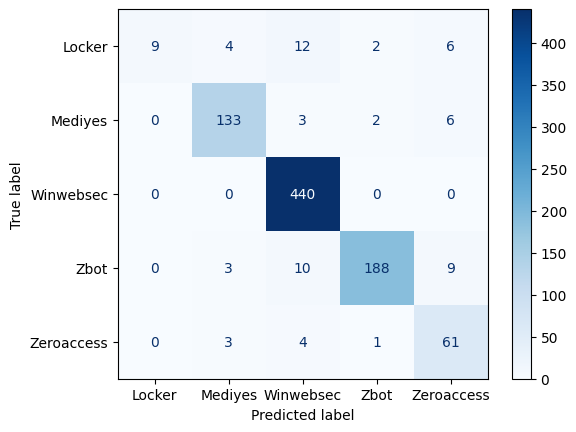

=====loading vgg16_iid/2_weights.npy=======
28/28 [==============================] - 7s 241ms/step
[[ 12   0   9   4   8]
 [  0 127   5   4   8]
 [  0   0 440   0   0]
 [  0   2   5 201   2]
 [  0   0   1   4  64]]
              precision    recall  f1-score   support

           0     1.0000    0.3636    0.5333        33
           1     0.9845    0.8819    0.9304       144
           2     0.9565    1.0000    0.9778       440
           3     0.9437    0.9571    0.9504       210
           4     0.7805    0.9275    0.8477        69

    accuracy                         0.9420       896
   macro avg     0.9330    0.8261    0.8479       896
weighted avg     0.9460    0.9420    0.9373       896



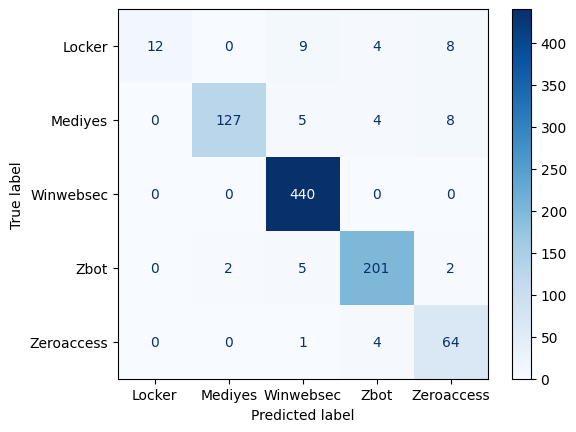

=====loading vgg16_iid/3_weights.npy=======
28/28 [==============================] - 6s 229ms/step
[[ 10   1   8   3  11]
 [  0 133   0   3   8]
 [  0   0 440   0   0]
 [  0   1   6 200   3]
 [  0   0   1   1  67]]
              precision    recall  f1-score   support

           0     1.0000    0.3030    0.4651        33
           1     0.9852    0.9236    0.9534       144
           2     0.9670    1.0000    0.9832       440
           3     0.9662    0.9524    0.9592       210
           4     0.7528    0.9710    0.8481        69

    accuracy                         0.9487       896
   macro avg     0.9342    0.8300    0.8418       896
weighted avg     0.9545    0.9487    0.9433       896



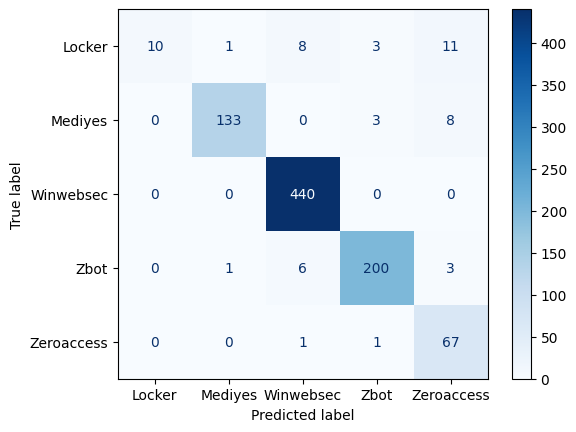

{
   "accuracy": {
      "server": {
         "1": 0.9274553571428571,
         "2": 0.9419642857142857,
         "3": 0.9486607142857143
      }
   },
   "aggregated_f1": {
      "server": {
         "1": 0.8128894015604414,
         "2": 0.8479101541296835,
         "3": 0.8418190800372518
      }
   },
   "aggregated_recall": {
      "server": {
         "1": 0.7951268900181944,
         "2": 0.8260519794215446,
         "3": 0.830007371855198
      }
   },
   "aggregated_precision": {
      "server": {
         "1": 0.9172463889287329,
         "2": 0.9330335279740953,
         "3": 0.9342421431722847
      }
   }
}


In [13]:

script_dirs = ['vgg16_iid']
rounds = 3
roundRange = np.arange(1, rounds + 1, dtype=int)
temp = {
    "accuracy": {},
    "f1-score": {},
    "precision": {},
    "recall": {}
}
model = get_base_model('VGG16')
for script_dir in script_dirs:
    # loop through the results of each round
    for i in roundRange:
        print(f"=====loading {script_dir}/{i}_weights.npy=======")
        # set weight
        latest_params=np.load(f'./weights/{script_dir}/{i}_weights.npy',allow_pickle=True)
        latest_weights = parameters_to_ndarrays(latest_params[0])
        

        model.set_weights(latest_weights)

        #Test the model
        y_pred = model.predict(X_valid)
        y_pred_bool = np.argmax(y_pred, axis=1)
        temp["accuracy"][f"{i}"] = accuracy_score(y_valid, y_pred_bool)
        temp["f1-score"][f"{i}"] = f1_score(y_valid, y_pred_bool , average="macro",zero_division=0)
        temp["precision"][f"{i}"] = precision_score(y_valid, y_pred_bool , average="macro",zero_division=0)
        temp["recall"][f"{i}"] = recall_score(y_valid, y_pred_bool , average="macro",zero_division=0)
        cfs = confusion_matrix(y_valid, y_pred_bool )
        print(cfs)
        print(classification_report(y_valid, y_pred_bool ,zero_division=0, digits= 4))
        display = ConfusionMatrixDisplay(cfs, display_labels=Categories).plot(  cmap=plt.cm.Blues,)
        plt.show()


    print(json.dumps({
                "accuracy": {
            "server": temp["accuracy"]
        },
                "aggregated_f1": {
            "server": temp["f1-score"]
        }
        , 
        
                "aggregated_recall": {
            "server": temp["recall"]
        
        },        
                "aggregated_precision": {
            "server": temp["precision"]
        
        },    
    }, indent=3
    
    ))
